In [1]:
import os
from pprint import pprint
import sys
import json

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy import stats
from scipy.signal import find_peaks, hilbert
import pickle

project_root = '..'
sys.path.append(project_root)

from sleeprnn.common import viz, constants
from sleeprnn.helpers import reader, plotter, misc, performer
from sleeprnn.detection import metrics, det_utils, ensemble
from figs_thesis import fig_utils
from baselines_scripts.butils import get_partitions
from sleeprnn.detection.feeder_dataset import FeederDataset
from sklearn.linear_model import LinearRegression, HuberRegressor
from sleeprnn.data import utils

RESULTS_PATH = os.path.join(project_root, 'results')
BASELINES_PATH = os.path.join(project_root, 'resources', 'comparison_data', 'baselines_2021')

%matplotlib inline
viz.notebook_full_width()

In [2]:
mass = reader.load_dataset('mass_ss', load_checkpoint=True)
signal = mass.get_subject_signal(1, normalize_clip=False, which_expert=1)
marks_ss = mass.get_subject_stamps(1, which_expert=1, pages_subset='n2')
mass = reader.load_dataset('mass_kc', load_checkpoint=True)
marks_kc = mass.get_subject_stamps(1, which_expert=1, pages_subset='n2')
print(marks_ss.shape, marks_kc.shape)

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.672256548159844
Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_kc with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.672256548159844
(1044, 2) (409, 2)


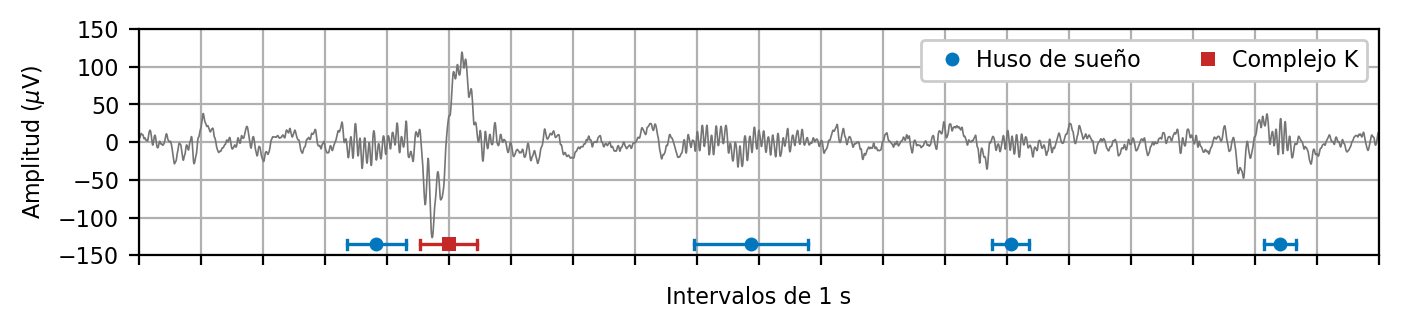

In [95]:
save_figure = True

which_kc = 195

left_context = 5
window_duration = 20
fs = 200


center_sample = int(marks_kc[which_kc].mean())
start_sample = int(center_sample - left_context * fs)
end_sample = int(start_sample + window_duration * fs)
time_axis = np.arange(0, end_sample - start_sample) / fs

fig, ax = plt.subplots(1, 1, figsize=(8, 1.5), dpi=200)

ax.plot(time_axis, signal[start_sample:end_sample], linewidth=0.6, color=viz.GREY_COLORS[6])

mark_level = -135
mark_linewidth = 1.2
spindles = utils.filter_stamps(marks_ss, start_sample, end_sample)
label = "Huso de sueño"
for m in spindles:
    m = m - start_sample
    if m[1] < 5 * fs:
        m[1] = m[1] - 10
    ax.plot(m / fs, [mark_level, mark_level], linewidth=mark_linewidth, color=viz.PALETTE['blue'])
    ax.plot([m[0] / fs, m[0] / fs], [mark_level - 6, mark_level + 6], linewidth=mark_linewidth, color=viz.PALETTE['blue'])
    ax.plot([m[1] / fs, m[1] / fs], [mark_level - 6, mark_level + 6], linewidth=mark_linewidth, color=viz.PALETTE['blue'])
    ax.plot(m.mean() / fs, mark_level, color=viz.PALETTE['blue'], marker='o', markersize=5, markeredgewidth=0, linestyle="none", label=label)
    label = None
kcomplexes = utils.filter_stamps(marks_kc, start_sample, end_sample)
label = "Complejo K"
for m in kcomplexes:
    m = m - start_sample
    ax.plot(m / fs, [mark_level, mark_level], linewidth=mark_linewidth, color=viz.PALETTE['red'])
    ax.plot([m[0] / fs, m[0] / fs], [mark_level - 6, mark_level + 6], linewidth=mark_linewidth, color=viz.PALETTE['red'])
    ax.plot([m[1] / fs, m[1] / fs], [mark_level - 6, mark_level + 6], linewidth=mark_linewidth, color=viz.PALETTE['red'])
    ax.plot(m.mean() / fs, mark_level, color=viz.PALETTE['red'], marker='s', markersize=5, markeredgewidth=0, linestyle="none", label=label)
    label = None

ax.tick_params(labelsize=8)
ax.set_xlabel("Intervalos de 1 s", fontsize=8)
ax.set_ylabel("Amplitud ($\mu$V)", fontsize=8)
ax.set_yticks([-150, -100, -50, 0, 50, 100, 150])
ax.set_ylim([-150, 150])
ax.set_xticks(np.arange(0, window_duration + 0.001, 1))
ax.set_xticklabels([])
ax.set_xlim([0, window_duration])
ax.grid()
ax.legend(fontsize=8, ncol=2, frameon=True, framealpha=1, handletextpad=0.1)

if save_figure:
    # Save figure
    fname_prefix = "viz_ss_kc"
    plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.4)

plt.show()